# Instalación e importación de paquetes

In [ ]:
!apt-get install openjdk-8-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark

In [ ]:
import pandas as pd
import networkx as net
import plotly.express as px
import plotly.graph_objects as go
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import *  
from pyspark.sql.functions import *
from math import radians, cos, sin, asin, sqrt 

# Extracción de datos

In [ ]:
import json
with open("/content/201812_Usage_Bicimad_Diciembre.json", encoding='latin1') as f:
    data = f.readlines()

In [ ]:
rdd = sc.textFile('201812_Usage_Bicimad_Diciembre.json')

In [ ]:
def usersalida(line):
  """
  Esta funcion hace un mapeo por filas de la base de datos de BiciMad,
  devolviendo un par (start, user) siendo "start" el inicio de un
  trayecto o salida de una estacion y "user" el usuario que utiliza
  el servicio.
  
  Parámetros
  ----------
  @Type line : Diccionario

  Return
  ----------
  @Type start : int
  @Type user : string
  """
  data=json.loads(line)
  user=data["user_day_code"]
  start=data["idplug_station"]
  return start, user

def userllegada(line):
  """
  Esta funcion hace un mapeo por filas de la base de datos de BiciMad,
  devolviendo un par (end, user) siendo "end" el final de un trayecto
  o llegada a una estacion y "user" el usuario que utiliza el servicio.
  
  Parámetros
  ----------
  @Type line : Diccionario

  Return
  ----------
  @Type end : int
  @Type user : string
  """
  data=json.loads(line)
  user=data["user_day_code"]
  end=data["idunplug_station"]
  return  end, user

In [ ]:
salidas=rdd.map(usersalida)
llegadas=rdd.map(userllegada)

1. Conteo de la cantidad de llegadas que se producen en cada estación.

2. Conteo de la cantidad de llegadas que se producen en cada estación.

3. Convertimos los RDDs a dataframes.

In [ ]:
lista_salidas=salidas.groupBy(lambda x: x[0]).mapValues(lambda x: len(list(x))).collect()
salida0 = sc.parallelize(lista_salidas)

In [ ]:
lista_llegadas=llegadas.groupBy(lambda x: x[0]).mapValues(lambda x: len(list(x))).collect()
llegada0 = sc.parallelize(lista_llegadas)

In [ ]:
salida = salida0.toDF()
llegada = llegada0.toDF()

**Excel**

In [ ]:
est_arch = pd.read_excel("/content/2018_Julio_Bases_Bicimad_EMT.xlsx")
estaciones_excel = est_arch.drop(['name',"number","longitude","latitude","address"],axis = 1)
estaciones_excel.head()

,total_bases,id
0,24,153
1,24,138
2,27,102
3,24,104
4,24,71


# Procesamiento de las estaciones



1. Renombramos las columnas del dataframe.
2. Eliminamos las columnas que no necesitamos.
3. Convertimos estaciones_excel en un spark dataframe.
4. Juntamos los dos dataframes.



In [ ]:
salida1 = salida.withColumnRenamed('_1','estacion').withColumnRenamed('_2','Salidas')
llegada1 = llegada.withColumnRenamed('_1','estacion1').withColumnRenamed('_2','Llegadas')

In [ ]:
estaciones_df = spark.createDataFrame(estaciones_excel)

In [ ]:
usuarios = salida1.join(llegada1,llegada1.estacion1==salida1.estacion, 'inner')
usuarios = usuarios.drop('estacion1')

# Dataframe final

La idea es hallar el flujo de cada estación. Entendemos el flujo como la suma de llegadas y salidas.

1. Unimos los dos dataframes por sus identificadores ("id", "Ident").
2. Creamos una columna llamada "Flujo" para medir el flujo de viajes (llegadas más salidas).
3. Ordenamos "Flujo" por orden descendente.


In [ ]:
estaciones_df = estaciones_df.withColumnRenamed("id","IDent")

estaciones_df1 = estaciones_df.join(usuarios,usuarios.estacion==estaciones_df.IDent, 'inner')
estaciones_df1 = estaciones_df1.drop('IDent')
suma = estaciones_df1.withColumn('Flujo',estaciones_df1.Llegadas + estaciones_df1.Salidas)

optimos = suma.sort(['Flujo'],ascending = False)
optimos.show()

+-----------+--------+-------+--------+-----+
|total_bases|estacion|Salidas|Llegadas|Flujo|
+-----------+--------+-------+--------+-----+
|         24|      57|     99|     100|  199|
|         27|      43|     98|      94|  192|
|         24|     129|     78|      85|  163|
|         24|     149|     80|      83|  163|
|         24|     163|     73|      84|  157|
|         24|      83|     76|      81|  157|
|         27|      90|     83|      71|  154|
|         24|     135|     86|      62|  148|
|         24|     168|     73|      67|  140|
|         24|     133|     65|      61|  126|
|         21|      58|     64|      61|  125|
|         24|      19|     64|      60|  124|
|         24|      38|     59|      60|  119|
|         24|     128|     54|      63|  117|
|         24|      64|     59|      58|  117|
|         24|      46|     53|      59|  112|
|         24|     136|     58|      53|  111|
|         24|       1|     57|      54|  111|
|         24|     161|     52|    

Realizamos una consulta para averiguar la suma total de los viajes realizados.

In [ ]:
# Realizamos una consulta para averiguar la suma total de los viajes realizados.
optimos.createOrReplaceTempView('est_arch')
suma_total = spark.sql('select sum(Flujo) from est_arch ')
suma_total.show()

+----------+
|sum(Flujo)|
+----------+
|     10451|
+----------+



**Para usar los mismos datos de excel en las rdd's**

In [ ]:
# Quita las estaciones que no tienen coordenadas en el excel.
def sin_coor_gnrl(v,c):
  i=0
  v_f=[]
  while i<len(c):
    j=0
    while j<len(v):
      if v[j][0]==c[i][0]:
        v_f.append(v[j])
        j+=1
      else:
        j+=1
    i+=1
  return v_f

In [ ]:
# Obtenemos una lista de las estaciones y sus coordenadas.
est_df = spark.createDataFrame(est_arch)
estaciones_coordenadas = est_df.drop(*['name',"number",'total_bases',"address"])
estaciones_coordenadas_rdd=estaciones_coordenadas.rdd.collect()
lista_coordenadas=[]
for i in estaciones_coordenadas_rdd:
  lista_coordenadas.append((i[0],i[1],i[2]))

In [ ]:
# Obtenemos de las listas halladas una lista de las estaciones que tienen coordenadas.
salidas_coor=sin_coor_gnrl(lista_salidas,lista_coordenadas)
llegadas_coor=sin_coor_gnrl(lista_llegadas,lista_coordenadas)

# Las conviertimos a rdd.
salidas_rdd=sc.parallelize(salidas_coor)
llegadas_rdd=sc.parallelize(llegadas_coor)

# Es la relación de las bases con la estación, transformada del archivo excel a rdd.
total_bases=estaciones_df.rdd.map(tuple) 

# Criterio de optimalidad

In [ ]:
# Creamos una función udf para transformar los True en "Optimo" y los False en "No Optimo".
def rend(rendimiento):
  if rendimiento==True:
    return 'Optimo'
  else:
    return 'No Optimo'

usoUdf = udf(rend)

In [ ]:
# Calculamos el flujo total.
suma_llegada=llegadas_rdd.map(lambda x: x[1]).reduce(lambda x, y: x+y)
suma_salida=salidas_rdd.map(lambda x: x[1]).reduce(lambda x, y: x+y)
suma_total=suma_llegada+suma_salida

In [ ]:
optimos1 = optimos.withColumn('Frecuencia',(optimos.Flujo/suma_total)*100)
optimos1 = optimos1.withColumn('Demanda_Deficit',estaciones_df1.Llegadas - estaciones_df1.Salidas)
optimos1 = optimos1.withColumn("Rendimiento",usoUdf(((optimos1.Demanda_Deficit>=(-(optimos1.total_bases)/2)) & (optimos1.Demanda_Deficit<=((optimos1.total_bases)/2)) & (optimos1.Flujo > optimos1.total_bases))))
optimos1.show()
optimos1.toPandas().to_csv('optimos_Diciembre.csv')

+-----------+--------+-------+--------+-----+------------------+---------------+-----------+
|total_bases|estacion|Salidas|Llegadas|Flujo|        Frecuencia|Demanda_Deficit|Rendimiento|
+-----------+--------+-------+--------+-----+------------------+---------------+-----------+
|         24|      57|     99|     100|  199|1.9041240072720313|              1|     Optimo|
|         27|      43|     98|      94|  192|1.8371447708353268|             -4|     Optimo|
|         24|     149|     80|      83|  163|1.5596593627404076|              3|     Optimo|
|         24|     129|     78|      85|  163|1.5596593627404076|              7|     Optimo|
|         24|      83|     76|      81|  157|1.5022485886518036|              5|     Optimo|
|         24|     163|     73|      84|  157|1.5022485886518036|             11|     Optimo|
|         27|      90|     83|      71|  154|1.4735432016075016|            -12|     Optimo|
|         24|     135|     86|      62|  148|1.4161324275188978|      

Para no calcular cada cosa a mano

In [ ]:
# Nos devuelve el número de veces que se sale de una estacion (para usarlo más tarde).
def mismaestacion(x):
  p=0
  for i in range(len(lista_salidas)):
    if (x[0] == lista_salidas[i][0])==True:
      p=lista_salidas[i][1]
  return p

In [ ]:
# Nos devuelve las estaciones con su demanda/deficit y el número de bases.
def deficit_bases(u,v):
  l=[]
  for i in range(len(u)):
    for j in range(len(v)):
      if u[i][1]==v[j][0]:
        l.append((v[j][0],v[j][1],u[i][0]))
        break
  return l

In [ ]:
# Nos genera una lista ordenada.
def genera_x(x):
  l=[]
  for i in range(len(x)):
    l.append((i+1))
  return l

In [ ]:
# Calcula el rendimiento de una estación.
def rendimiento(x):
  p=False
  for i in range(len(demanda_bases)):
    if x[0]==demanda_bases[i][0]:
      if demanda_bases[i][1]>=-(demanda_bases[i][2]/2) and demanda_bases[i][1]<=(demanda_bases[i][2]/2) and x[1]>demanda_bases[i][2]:
        p=True
  return p

In [ ]:
# Obtenemos el uso de una estación.
suma_rdd=llegadas_rdd.map(lambda x: (x[0],x[1]+mismaestacion(x))).sortBy(lambda x: x[1],ascending=False).collect()
# Obtenemos el déficit de una estación.
demanda_deficit_rdd=llegadas_rdd.map(lambda x: (x[0],x[1]-mismaestacion(x))).collect()

bases=total_bases.collect()
demanda_bases=deficit_bases(bases,demanda_deficit_rdd)
suma_rendimiento=sc.parallelize(suma_rdd)

# Obtención de datos.
suma_masuo=suma_rendimiento.filter(lambda x: rendimiento(x)==True).map(lambda x: x[1]).take(20)
suma_masuno=suma_rendimiento.filter(lambda x: rendimiento(x)==False).map(lambda x: x[1]).take(20)
suma_menosuo=suma_rendimiento.sortBy(lambda x: x[1],ascending=True).filter(lambda x: rendimiento(x)==True).map(lambda x: x[1]).take(20)
suma_menosuno=suma_rendimiento.sortBy(lambda x: x[1],ascending=True).filter(lambda x: rendimiento(x)==False).map(lambda x: x[1]).take(20)

# Estaciones Más Usadas y Óptimas

In [ ]:
usadas_optimas = optimos1.filter(optimos1.Rendimiento=="Optimo")
colum=["Salidas","Llegadas","Rendimiento"]
usadas_optimas = usadas_optimas.drop(*colum)
usadas_optimas.show()

+-----------+--------+-----+------------------+---------------+
|total_bases|estacion|Flujo|        Frecuencia|Demanda_Deficit|
+-----------+--------+-----+------------------+---------------+
|         24|      57|  199|1.9041240072720313|              1|
|         27|      43|  192|1.8371447708353268|             -4|
|         24|     129|  163|1.5596593627404076|              7|
|         24|     149|  163|1.5596593627404076|              3|
|         24|      83|  157|1.5022485886518036|              5|
|         24|     163|  157|1.5022485886518036|             11|
|         27|      90|  154|1.4735432016075016|            -12|
|         24|     168|  140|1.3395847287340925|             -6|
|         24|     133|  126|1.2056262558606832|             -4|
|         21|      58|  125|1.1960577935125827|             -3|
|         24|      19|  124| 1.186489331164482|             -4|
|         24|      38|  119|1.1386470194239784|              1|
|         24|     128|  117|1.1195100947

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = genera_x(suma_masuo),
        y = suma_masuo
    ))

fig.add_trace(
    go.Bar(
        x = genera_x(suma_masuo),
        y = suma_masuo
    ))

fig.update_layout(
    title='Más Usadas y Óptimas',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Usos',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig.show()

En el caso de las estaciones más usadas y óptimas, la estación más transitada con 199 trayectos es la nº57, que corresponde al 1.9% de los trayectos totales.

Como se puede observar en el diagrama el número total de trayectos por estación se reduce rapidamente. Esto nos da a entender, que la mayor parte de los usos de bicicletas, se concentra en un número reducido de estaciones.

# Estaciones Más Usadas y No Óptimas

In [ ]:
usadas_noptimas = optimos1.filter(optimos1.Rendimiento=="No Optimo")
colum=["Salidas","Llegadas", "Rendimiento"]
usadas_noptimas = usadas_noptimas.drop(*colum)
usadas_noptimas.show()

+-----------+--------+-----+-------------------+---------------+
|total_bases|estacion|Flujo|         Frecuencia|Demanda_Deficit|
+-----------+--------+-----+-------------------+---------------+
|         24|     135|  148| 1.4161324275188978|            -24|
|         27|       6|  105| 1.0046885465505693|             15|
|         24|     132|  105| 1.0046885465505693|            -15|
|         24|       3|   75| 0.7176346761075495|             13|
|         24|      60|   75| 0.7176346761075495|             13|
|         24|      84|   72| 0.6889292890632476|             16|
|         21|      16|   55| 0.5262654291455363|             17|
|         24|      47|   55| 0.5262654291455363|             17|
|         24|     110|   49|0.46885465505693236|            -17|
|         24|      18|   47|  0.449717730360731|             17|
|         24|     125|   37|0.35403310687972445|            -13|
|         27|     101|   27|0.25834848339871785|             -7|
|         24|      11|   

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = genera_x(suma_masuno),
        y = suma_masuno
    ))

fig.add_trace(
    go.Bar(
        x = genera_x(suma_masuno),
        y = suma_masuno
    ))

fig.update_layout(
    title='Más Usadas y No Óptimas',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Usos',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig.show()

En el caso de las estaciones más usadas y no óptimas, la estación más transitada con 148 trayectos es la nº135, que corresponde al 1.41% de los trayectos totales.

Como se puede observar en el histograma, el número total de trayectos por estación se reduce drasticamente. De cualquier manera, era de esperar que la mayor parte de las estaciones no óptimas tuviesen un uso reducido, de ahí que decrezca tanto la gráfica.

# Estaciones Menos Usadas y Óptimas

In [ ]:
musadas_optimas = optimos1.sort(["Frecuencia"],ascending=True).filter(optimos1.Rendimiento=="Optimo")
colum=["Salidas","Llegadas", "Rendimiento"]
musadas_optimas = musadas_optimas.drop(*colum)
musadas_optimas.show()

+-----------+--------+-----+-------------------+---------------+
|total_bases|estacion|Flujo|         Frecuencia|Demanda_Deficit|
+-----------+--------+-----+-------------------+---------------+
|         12|     165|   17| 0.1626638599177112|             -1|
|         24|     147|   25|0.23921155870251654|             -5|
|         24|     140|   25|0.23921155870251654|              3|
|         24|     148|   29| 0.2774854080949192|             -5|
|         24|     158|   29| 0.2774854080949192|              1|
|         24|      94|   30| 0.2870538704430198|              6|
|         24|     159|   30| 0.2870538704430198|             -4|
|         24|      32|   30| 0.2870538704430198|              4|
|         24|      93|   31| 0.2966223327911205|            -11|
|         24|     122|   31| 0.2966223327911205|              3|
|         18|     111|   32| 0.3061907951392211|             -8|
|         24|     138|   32| 0.3061907951392211|             -6|
|         24|     117|   

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = genera_x(suma_menosuo),
        y = suma_menosuo
    ))

fig.add_trace(
    go.Bar(
        x = genera_x(suma_menosuo),
        y = suma_menosuo
    ))

fig.update_layout(
    title='Menos Usadas y Óptimas',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Usos',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig.show()

En el caso de las estaciones menos usadas y óptimas, la estación menos transitada con 17 trayectos es la nº165, que corresponde al 0.16% de los trayectos totales.

Como podemos observar el número de usos por estación, se encuentra entre 15 y 40, esto quiere decir que hay bastantes estaciones con un uso relativamente reducido entre las óptimas.

# Estaciones Menos Usadas y No Óptimas

In [ ]:
musadas_noptimas = optimos1.sort(["Frecuencia"],ascending=True).filter(optimos1.Rendimiento=="No Optimo")
colum=["Salidas","Llegadas","Rendimiento"]
musadas_noptimas = musadas_noptimas.drop(*colum)
musadas_noptimas.show()

+-----------+--------+-----+-------------------+---------------+
|total_bases|estacion|Flujo|         Frecuencia|Demanda_Deficit|
+-----------+--------+-----+-------------------+---------------+
|         24|     119|   11|0.10525308582910727|             -1|
|         24|     151|   15| 0.1435269352215099|             -5|
|         24|     173|   17| 0.1626638599177112|             -5|
|         21|     109|   17| 0.1626638599177112|             11|
|         24|      92|   18| 0.1722323222658119|              0|
|         24|     146|   18| 0.1722323222658119|             -4|
|         24|     144|   18| 0.1722323222658119|             -2|
|         24|     105|   19|0.18180078461391255|              1|
|         24|     143|   19|0.18180078461391255|              5|
|         24|     107|   20| 0.1913692469620132|             -8|
|         24|      88|   20| 0.1913692469620132|             -8|
|         30|      21|   20| 0.1913692469620132|             -6|
|         24|     120|   

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = genera_x(suma_menosuno),
        y = suma_menosuno
    ))

fig.add_trace(
    go.Bar(
        x = genera_x(suma_menosuno),
        y = suma_menosuno
    ))

fig.update_layout(
    title='Menos Usadas y No Óptimas',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Usos',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig.show()

En el caso de las estaciones menos usadas y no óptimas, la estación menos transitada con 11 trayectos es la nº119, que corresponde al 0.10% de los trayectos totales.

Como vemos en el histograma, encontramos un salto muy importante en el número de usos. Al estar ordenado el histograma por el número de usos, las bases no óptimas a partir de esta, se caracterizarán por un uso irregular, teniendo en cuenta que le criterio de optimalidad, distingue que las estaciones son no óptimas, si son muy poco frecuentadas o tienen un flujo irregular.

En referencia a las primeras estaciones del histograma, al tener un uso reducido, será esta la razón por la que no son óptimas.

# Mejora Bases

In [ ]:
mejoras =optimos1.filter(optimos1.Rendimiento == 'No Optimo')
mejoras.show()

+-----------+--------+-------+--------+-----+-------------------+---------------+-----------+
|total_bases|estacion|Salidas|Llegadas|Flujo|         Frecuencia|Demanda_Deficit|Rendimiento|
+-----------+--------+-------+--------+-----+-------------------+---------------+-----------+
|         24|     135|     86|      62|  148| 1.4161324275188978|            -24|  No Optimo|
|         27|       6|     45|      60|  105| 1.0046885465505693|             15|  No Optimo|
|         24|     132|     60|      45|  105| 1.0046885465505693|            -15|  No Optimo|
|         24|       3|     31|      44|   75| 0.7176346761075495|             13|  No Optimo|
|         24|      60|     31|      44|   75| 0.7176346761075495|             13|  No Optimo|
|         24|      84|     28|      44|   72| 0.6889292890632476|             16|  No Optimo|
|         21|      16|     19|      36|   55| 0.5262654291455363|             17|  No Optimo|
|         24|      47|     19|      36|   55| 0.526265429145

In [ ]:
mejoras2 = mejoras.withColumn('Nuevas_Total_Bases',(mejoras.total_bases + (mejoras.Demanda_Deficit/abs(mejoras.Demanda_Deficit))*round(mejoras.total_bases*0.3)))
mejoras2 = mejoras2.withColumn("Nuevo_Rendimiento", ((mejoras2.Demanda_Deficit>=(-(mejoras2.Nuevas_Total_Bases)/2)) & (mejoras2.Demanda_Deficit<=((mejoras2.Nuevas_Total_Bases)/2)) & (mejoras2.Flujo > mejoras2.Nuevas_Total_Bases)))
mejoras2 = mejoras2.withColumn("Nuevo_Rendimiento", usoUdf(mejoras2.Nuevo_Rendimiento))
mejoras2.show()

+-----------+--------+-------+--------+-----+-------------------+---------------+-----------+------------------+-----------------+
|total_bases|estacion|Salidas|Llegadas|Flujo|         Frecuencia|Demanda_Deficit|Rendimiento|Nuevas_Total_Bases|Nuevo_Rendimiento|
+-----------+--------+-------+--------+-----+-------------------+---------------+-----------+------------------+-----------------+
|         24|     135|     86|      62|  148| 1.4161324275188978|            -24|  No Optimo|              17.0|        No Optimo|
|         27|       6|     45|      60|  105| 1.0046885465505693|             15|  No Optimo|              35.0|           Optimo|
|         24|     132|     60|      45|  105| 1.0046885465505693|            -15|  No Optimo|              17.0|        No Optimo|
|         24|       3|     31|      44|   75| 0.7176346761075495|             13|  No Optimo|              31.0|           Optimo|
|         24|      60|     31|      44|   75| 0.7176346761075495|             13|  

1. Realizamos un filtrado para saber la cantidad de óptimos-no óptimos y sus corespondientes mejoras. 
2. Histograma con las correspondientes cantidades.

In [ ]:
optimos1.createOrReplaceTempView("filtrado")
booleano = spark.sql("select Rendimiento, count(Rendimiento) as Cantidad from filtrado group by Rendimiento")
booleano_panda = booleano.toPandas()
booleano.show()

+-----------+--------+
|Rendimiento|Cantidad|
+-----------+--------+
|  No Optimo|      29|
|     Optimo|     137|
+-----------+--------+



In [ ]:
fig = px.bar(booleano_panda, x="Rendimiento", y="Cantidad", color='Cantidad',
             height=400)

fig.update_layout(
    title='Recuento de Rendimiento',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Usos',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1 
)

fig.show()

Como se puede apreciar en el histograma del recuento de las estaciones, en este mes exiten bastantes mas estaciones óptimas que estaciones no óptimas

In [ ]:
# Hacemos un nuevo recuento para ver como evolucionan las estaciones no óptimas después de aplicar el criterio de mejora
mejoras2.createOrReplaceTempView("filtrado")
booleano1 = spark.sql("select Nuevo_Rendimiento, count(Nuevo_Rendimiento) as Cantidad from filtrado group by Nuevo_Rendimiento")
booleano_panda1 = booleano1.toPandas()
booleano1.show()

+-----------------+--------+
|Nuevo_Rendimiento|Cantidad|
+-----------------+--------+
|        No Optimo|      18|
|           Optimo|      11|
+-----------------+--------+



In [ ]:
fig = px.bar(booleano_panda1, x="Nuevo_Rendimiento", y="Cantidad", color='Cantidad',
             height=400)
fig.update_layout(
    title='No óptimas mejoradas',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Usos',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, 
    bargroupgap=0.1 
)
fig.show()

Como podemos apreciar bastantes estaciones que originalmente era no óptimas, despues del aplicar el criterio de mejora pasan a ser estaciones óptimas

# Visualización de datos.

**Histograma de las estaciones más transitadas**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(x=genera_x(suma_masuo),
                y=suma_masuo,
                name='Óptima',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=genera_x(suma_masuno),
                y=suma_masuno,
                name='No Óptima',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='Comparación más usadas',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Usos',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)
fig.show()

**Histogramas de las estaciones menos transitadas**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(x=genera_x(suma_menosuo),
                y=suma_menosuo,
                name='Óptima',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=genera_x(suma_menosuno),
                y=suma_menosuno,
                name='No Óptima',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='Comparación menos usadas',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Usos',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, 
    bargroupgap=0.1
)
fig.show()

**Para coger longitudes y latitudes**

In [ ]:
def coger_long_lat(n):
  longitud=[]
  latitud=[]
  for i in range(len(n)):
    longitud.append(n[i][1])
    latitud.append(n[i][2])
  return longitud,latitud

In [ ]:
# Nos muestra las coordenadas de los puntos que elijamos.
def coor_nodo(lista0,lista1):
  lista_definitiva=[]
  for i in range(len(lista0)):
    j=0
    continuar=True
    while j<len(lista1) and continuar:
      if float(lista0[i])==lista1[j][0]:
        lista_definitiva.append(lista1[j])
        continuar=False
      else:
        j+=1
  return (lista_definitiva)

In [ ]:
# Te devuelve la distancia en km entre dos puntos con sus coordenadas terrestres
def haversine(lon1, lat1, lon2, lat2): 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])  
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    c = 2 * asin(sqrt((a)))
    km = 6367 * c 
    return km

**Mapa de Madrid con las más usados**

In [ ]:
suma_masuo_mapa=suma_rendimiento.filter(lambda x: rendimiento(x)==True).map(lambda x: x[0]).take(20)
n_mas=coor_nodo(suma_masuo_mapa,lista_coordenadas)

coordenadas_aux=coger_long_lat(n_mas)
long_final=list(set(coordenadas_aux[0]))
lat_final=list(set(coordenadas_aux[1]))

In [ ]:
fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = long_final,
    lat = lat_final,
    marker = {'size': 10}))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = long_final,
    lat = lat_final,
    marker = {'size': 10}))


fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon':-3.695605 , 'lat': -3.695605},
        'style': "stamen-terrain",
        'center': {'lon': -3.684715, 'lat': 40.458532},
        'zoom': 1})

fig.show()

**Mapa de Madrid de las menos usados**

In [ ]:
suma_menosuo_mapa=suma_rendimiento.sortBy(lambda x: x[1],ascending=True).filter(lambda x: rendimiento(x)==True).map(lambda x: x[0]).take(20)
n_menos=coor_nodo(suma_menosuo_mapa,lista_coordenadas)

coordenadas_aux=coger_long_lat(n_menos)
long_final=list(set(coordenadas_aux[0]))
lat_final=list(set(coordenadas_aux[1]))

In [ ]:
fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = long_final,
    lat = lat_final,
    marker = {'size': 10}))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = long_final,
    lat = lat_final,
    marker = {'size': 10}))


fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon':-3.695605 , 'lat': -3.695605},
        'style': "stamen-terrain",
        'center': {'lon': -3.684715, 'lat': 40.458532},
        'zoom': 1})

fig.show()

# Grafos

Preparamos los datos

In [ ]:
suma_grafo=suma_rendimiento.take(20)
deficit_grafo=sc.parallelize(demanda_deficit_rdd)
comparacion_grafo=deficit_grafo.sortBy(lambda x: x[1],ascending=False).take(20)

In [ ]:
# Esta función hace un mapeo de todos los trayectos.
def trayectos(line):
  data=json.loads(line)
  start=data['idplug_station']
  end=data['idunplug_station']
  return start, end

In [ ]:
aristas = rdd.map(trayectos)

In [ ]:
# Comprueban si las estaciones que hemos cogido están unidas.
# Cuidado si cambias los datos suma_grafo y comparacion_grafo (tienen que ser de la misma forma).
def estanunidossuma(x):
  l=[]
  for i in range(len(suma_grafo)):
    if (x[0] in suma_grafo[i])==True and (x[1] in suma_grafo[i])==True:
      l.append((x[0],x[1]))
  return l

def estanunidosdeficit(x):
  l=[]
  for i in range(len(comparacion_grafo)):
    if (x[0] in comparacion_grafo[i])==True and (x[1] in comparacion_grafo[i])==True:
      l.append((x[0],x[1]))
  return l

In [ ]:
def userlines(line):
  data=json.loads(line)
  user=data["user_day_code"]
  start=data["idplug_station"]
  end=data["idunplug_station"]
  return (start, end), user

In [ ]:
# t es la cantidad de veces que se usa un trayecto
# tr son los trayectos de t, sin la cantidad de veces
trayecto=rdd.map(userlines)
t=trayecto.groupByKey().mapValues(lambda x: len(list(x))).collect()
tr=trayecto.groupByKey().mapValues(lambda x: len(list(x))).map(lambda x: (x[0])).collect()

In [ ]:
# Mira si un elemento (t) está en una lista (x).
def esta(t,x):
  p=False
  if t in x:
    p=True
  return p

In [ ]:
# Comprueba que si hay un trayecto de ida y vuelta sólo aparezca uno.
def mismotrayecto(x):
  l=[]
  for i in range(len(x)):
    if ((esta((x[i][0],x[i][1]),l))==False) and (((x[i][1],x[i][0]) in tr)==True):
      l.append((x[i][1],x[i][0]))
    else:
      l.append(x[i])
  return l

In [ ]:
# Crea los trayectos de las estaciones que están unidas
a1 = aristas.map(lambda x: ((x[0],x[1]), len(estanunidossuma(x))==1)).filter(lambda x: x[1]==True).map(lambda x: (x[0])).filter(lambda x: x[0]!=x[1]).collect()
a2 = aristas.map(lambda x: ((x[0],x[1]), len(estanunidosdeficit(x))==1)).filter(lambda x: x[1]==True).map(lambda x: (x[0])).filter(lambda x: x[0]!=x[1]).collect()

# Quitamos los que se repiten.
a1_aux=list(set(a1))
a2_aux=list(set(a2))

# Usamos la funcion mismotrayecto en los que hemos hallado.
trayecto1_aux = mismotrayecto(a1_aux)
trayecto2_aux = mismotrayecto(a2_aux)

# Volvemos a quitar los repetidos.
trayecto_suma=list(set(trayecto1_aux))
trayecto_deficit=list(set(trayecto2_aux))

**Veces que se usan los trayectos**

In [ ]:
# Mira si t está en x.
def esta_veces(t,x):
  p=False
  for i in range(len(x)):
    if t==x[i][0]:
      p=True
  return p

In [ ]:
# Comprueba que si hay un trayecto de ida y vuelta sólo aparezca uno.
def mismotrayecto_veces(x):
  l=[]
  for i in range(len(x)):
    if ((esta_veces((x[i][0][0],x[i][0][1]),l))==False) and (((x[i][0][1],x[i][0][0]) in tr)==True):
      l.append(((x[i][0][1],x[i][0][0]),x[i][1]))
    else:
      l.append(x[i])
  return l

In [ ]:
def sumar_lista(l):
  r=0
  for i in range(len(l)):
    r=r+l[i]
  return r

In [ ]:
tr1=mismotrayecto_veces(t)
nvt=sc.parallelize(tr1)
numero_veces_trayecto=nvt.groupByKey().mapValues(list).map(lambda x: (x[0],sumar_lista(x[1])))

In [ ]:
trayectos_peso_suma=numero_veces_trayecto.filter(lambda x: x[0] in trayecto_suma).collect()
trayectos_peso_deficit=numero_veces_trayecto.filter(lambda x: x[0] in trayecto_deficit).collect()

**Parte de Grafo**


Vamos a representar los trayectos que se hacen entre las estaciones elegidas:

De las más usadas:

In [ ]:
# Creamos el grafo.

g_suma=net.Graph()
for i in trayectos_peso_suma:
  g_suma.add_edge(str(i[0][0]),str(i[0][1]),veces=int(i[1]))
pos_suma=net.circular_layout(g_suma) #posiciones de los nodos
edge_labels_suma = net.get_edge_attributes(g_suma,"veces")

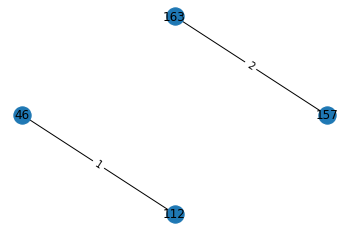

In [ ]:
net.draw_networkx_edge_labels(g_suma,pos_suma,edge_labels=edge_labels_suma)
net.draw_circular(g_suma, with_labels = True)

De las menos usadas:

In [ ]:
g_deficit=net.Graph()
for i in trayectos_peso_deficit:
  g_deficit.add_edge(str(i[0][0]),str(i[0][1]),veces=int(i[1]))
pos_deficit=net.circular_layout(g_deficit) #posiciones de los nodos
edge_labels_deficit = net.get_edge_attributes(g_deficit,"veces")

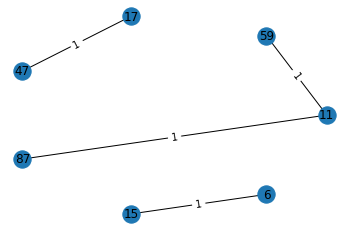

In [ ]:
net.draw_networkx_edge_labels(g_deficit,pos_deficit,edge_labels=edge_labels_deficit)
net.draw_circular(g_deficit, with_labels = True)

El trayecto más usado:

In [ ]:
numero_veces_trayecto.groupByKey().mapValues(list).map(lambda x: (x[0],sumar_lista(x[1]))).sortBy(lambda x: x[1],ascending=False).take(1)

[((133, 133), 24)]

# Algoritmos

Cálculo de datos

In [ ]:
#Vértices que usar en los grafos
suma_masuo_aux=suma_rendimiento.filter(lambda x: rendimiento(x)==True).map(lambda x: x[0]).take(20)
suma_menosuo_aux=suma_rendimiento.sortBy(lambda x: x[1],ascending=True).filter(lambda x: rendimiento(x)==True).map(lambda x: x[0]).take(20)
suma_masuo_grafo=list(set(suma_masuo_aux))
suma_menosuo_grafo=list(set(suma_menosuo_aux))

 **Kruskal**

In [ ]:
# Comprueba si los puntos que se quieren añadir estan en la lista (auxn).
def comprobacion(pa,auxn):
  p=[]
  r=[]
  pa_rdd=sc.parallelize(pa)
  t=pa_rdd.sortBy(lambda x: x[0]).take(1)
  for j in range(len(auxn)):
    if t[0][1] in auxn[j]:
      p.append(j)
    if t[0][2] in auxn[j]:
      r.append(j)
  return t,p,r

In [ ]:
# Unir una lista de listas en una sola lista.
def unir(x):
  l=[]
  for i in range(len(x)):
    for j in range(len(x[i])):
      l.append(x[i][j])
  return l

In [ ]:
def kruskal(n,pa):
  tray_final=[]
  auxn=[]
  pa_rdd=sc.parallelize(pa)
  t=pa_rdd.sortBy(lambda x: x[0]).take(1)
  pa.remove(t[0])
  tray_final.append(t[0])
  auxn.append([t[0][1],t[0][2]])
  while len(auxn[0])<len(n):
    b=comprobacion(pa,auxn)
    if len(b[1])== 1 and len(b[2])==1:
      if b[1][0]==b[2][0]:
        pa.remove(b[0][0])
      else:
        l=[]
        l.append(auxn[b[1][0]])
        l.append(auxn[b[2][0]])
        if b[1][0]<b[2][0]:
          auxn.pop(b[2][0])
          auxn.pop(b[1][0])
        else:
          auxn.pop(b[1][0])
          auxn.pop(b[2][0])
        laux=unir(l)
        auxn.append(laux)
        pa.remove(b[0][0])
        tray_final.append(b[0][0])
    elif len(b[1])==1 and len(b[2])==0:
      pa.remove(b[0][0])
      tray_final.append(b[0][0])
      auxn[b[1][0]].append(b[0][0][2])
    elif len(b[1])==0 and len(b[2])==1:
      pa.remove(b[0][0])
      tray_final.append(b[0][0])
      auxn[b[2][0]].append(b[0][0][1])
    else:
      pa.remove(b[0][0])
      tray_final.append(b[0][0])
      auxn.append([b[0][0][1],b[0][0][2]])
  return tray_final

Datos para el algoritmo

In [ ]:
# Creamos la lista de nodos
coordenadasK=coor_nodo(suma_masuo_grafo,lista_coordenadas)
nK_aux=sc.parallelize(coordenadasK)
nK=nK_aux.map(lambda x: x[0]).collect()
# Creampas la lista de las distancias con sus trayectos.
peso_aristak=[]
i=0
while i<len(coordenadasK)-1:
  j=i+1
  while j<len(coordenadasK):
    trayectok = haversine(coordenadasK[i][1],coordenadasK[i][2],coordenadasK[j][1],coordenadasK[j][2])
    peso_aristak.append((trayectok, coordenadasK[i][0],coordenadasK[j][0]))
    j+=1
  i+=1

Implementación

In [ ]:
grafo_Kruskal=kruskal(nK,peso_aristak) #Si se ha ejecutado y quieres volverlo a ejecutar, hay que volver a ejecutar los datos del algoritmo

In [ ]:
g_kruskal=net.Graph()
for i in grafo_Kruskal:
  g_kruskal.add_edge(str(i[1]),str(i[2]))

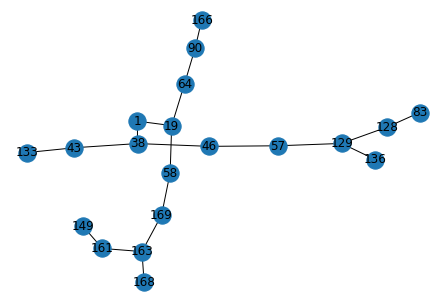

In [ ]:
net.draw(g_kruskal,with_labels = True)

**Prim**

In [ ]:
def prim(n,pa_rdd):
  prim=[]
  v0=input("Elige el primer vértice: (Un número del 1-"+str(len(n))+") ")
  aux1=pa_rdd.filter(lambda x: x[1]==n[int(v0)-1] or x[2]==n[int(v0)-1]).collect()
  mindist=coger_minimo(aux1)
  nodolist=pa_rdd.filter(lambda x: (x[1]==n[int(v0)-1] or x[2]==n[int(v0)-1]) and x[0]==mindist).collect()
  nodoadd=nodolist[0]
  prim.append(nodoadd)
  t=n[int(v0)-1]
  r=len(n)
  n.remove(nodoadd[1])
  n.remove(nodoadd[2])
  while len(prim)<r-1:
    sig_nodo=calculo_nodo(prim,pa_rdd,t,n)
    t=sig_nodo[1]
    prim.append(sig_nodo[0])
    n=sig_nodo[2]
    for k in range(len(n)):
      if t==n[k]:
        n.pop(k)
        break
  return prim

In [ ]:
def calculo_nodo(l,pa_rdd,t,n):
  l1=[]
  for i in range(len(l)):
    for j in range(1,3):
      siguiente_nodo=l[i][j] 
      aux2=pa_rdd.filter(lambda x: x[1]==siguiente_nodo or x[2]==siguiente_nodo).filter(lambda x: x[1] in n or x[2] in n)
      aux3=aux2.collect()
      mindist2=coger_minimo(aux3)
      nodolist2=aux2.filter(lambda x: x[0]==mindist2).collect()
      nodoadd2=nodolist2[0]
      l1.append(nodoadd2)
  l1_aux=sc.parallelize(l1)
  minimo=l1_aux.sortBy(lambda x: x[0]).take(1)
  for i in n:
    if i==minimo[0][1] or i==minimo[0][2]:
      t=i
  return minimo[0],t,n

In [ ]:
def coger_minimo(l):
  maxdist=pa_rdd.sortBy(lambda x: x[0],ascending=False).map(lambda x: x[0]).take(1)
  dist=maxdist[0]
  for i in range(len(l)):
    if dist>l[i][0]:
      dist=l[i][0]
  return dist

Datos para el algoritmo

In [ ]:
coordenadasP=coor_nodo(suma_menosuo_grafo,lista_coordenadas)
nP_aux=sc.parallelize(coordenadasP)
nP=nP_aux.map(lambda x: x[0]).collect()
peso_aristap=[]
i=0
while i<len(coordenadasP)-1:
  j=i+1
  while j<len(coordenadasP):
    trayectop = haversine(coordenadasP[i][1],coordenadasP[i][2],coordenadasP[j][1],coordenadasP[j][2])
    peso_aristap.append((trayectop, coordenadasP[i][0],coordenadasP[j][0]))
    j+=1
  i+=1
pa_rdd=sc.parallelize(peso_aristap)

Implementacion

In [ ]:
grafo_prim=prim(nP,pa_rdd) #Si se ha ejecutado y quieres volverlo a ejecutar, hay que volver a ejecutar los datos del algoritmo

Elige el primer vértice: (Un número del 1-20) 1


In [ ]:
g_prim=net.Graph()
for i in grafo_prim:
  g_prim.add_edge(str(i[1]),str(i[2]),weight=i[0])
pos=net.circular_layout(g_prim)
edge_labels = net.get_edge_attributes(g_prim, "weight")

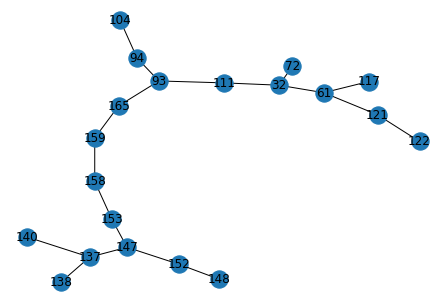

In [ ]:
net.draw(g_prim, with_labels = True)

**Longitud total del recorrido mínimo**

In [ ]:
kalculo_aux=sc.parallelize(grafo_Kruskal)
kalculo=kalculo_aux.map(lambda x: x[0]).reduce(lambda x,y: x+y)
kalculo

13.038471687695445

In [ ]:
palculo_aux=sc.parallelize(grafo_prim)
palculo=palculo_aux.map(lambda x: x[0]).reduce(lambda x,y: x+y)
palculo

12.315033890550552